In [1]:
# Feature Engineering - RFM Analysis
# RFM = Recency, Frequency, Monetary Value

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load data
df = pd.read_csv('../data/processed/online_retail_ii_cleaned.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalValue'] = df['Quantity'] * df['Price']

print("Data loaded for RFM feature engineering...")
print(f"Dataset shape: {df.shape}")

Data loaded for RFM feature engineering...
Dataset shape: (388206, 9)


In [2]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Feature Engineering - RFM Analysis

RFM (Recency, Frequency, Monetary) analysis is a proven method for customer segmentation. This step creates the features that will be used to segment customers in the next phase.

- **Recency:** How recently did the customer purchase? (Days since last purchase)
- **Frequency:** How often do they purchase? (Number of transactions)
- **Monetary:** How much do they spend? (Total customer value)

In [3]:
# Calculate RFM Metrics
# Set analysis date (day after the last transaction in our data)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Snapshot date for RFM calculation: {snapshot_date.date()}")

# Calculate RFM metrics for each customer
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency: Days since last purchase
    'Invoice': 'nunique',                                  # Frequency: Number of transactions
    'TotalValue': 'sum'                                      # Monetary: Total spending
}).reset_index()

# Rename columns
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

print("RFM metrics calculated!")
print(f"Number of customers in RFM analysis: {len(rfm)}")
print("\nFirst 5 customers:")
rfm.head()

Snapshot date for RFM calculation: 2011-12-10
RFM metrics calculated!
Number of customers in RFM analysis: 4303

First 5 customers:


,Customer ID,Recency,Frequency,Monetary
0,12347.0,2,7,4060.40
1,12348.0,75,4,1195.08
2,12349.0,19,1,1757.55
3,12350.0,310,1,334.40
4,12352.0,36,8,2506.04


### RFM Scoring

Customers are scored from 1-4 on each dimension (4 being best). For Recency, lower values are better, so the scoring is reversed.

In [4]:
# Create RFM scores (1-4, where 4 is best for Recency, 1 is worst)
# For Recency: Lower values are better (more recent), so we reverse the order
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1, 2, 3, 4])

# Convert scores to integers
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Create RFM segment string and total score
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

print("RFM scoring completed!")
print("\nRFM Score Distribution:")
print(rfm['RFM_Score'].value_counts().sort_index())
print("\nSample of scored customers:")
rfm.head(10)

RFM scoring completed!

RFM Score Distribution:
RFM_Score
3     296
4     506
5     483
6     501
7     425
8     425
9     413
10    383
11    378
12    493
Name: count, dtype: int64

Sample of scored customers:


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,12347.0,2,7,4060.40,4,4,4,444,12
1,12348.0,75,4,1195.08,2,3,3,233,8
2,12349.0,19,1,1757.55,3,1,4,314,8
3,12350.0,310,1,334.40,1,1,2,112,4
4,12352.0,36,8,2506.04,3,4,4,344,11
5,12353.0,204,1,89.00,1,1,1,111,3
6,12354.0,232,1,1079.40,1,1,3,113,5
7,12355.0,214,1,459.40,1,1,2,112,4
8,12356.0,23,3,2710.63,3,3,4,334,10
9,12357.0,33,1,6207.67,3,1,4,314,8


### RFM Distribution Analysis

Understanding the distribution of RFM metrics helps identify natural customer segments and informs the clustering approach.

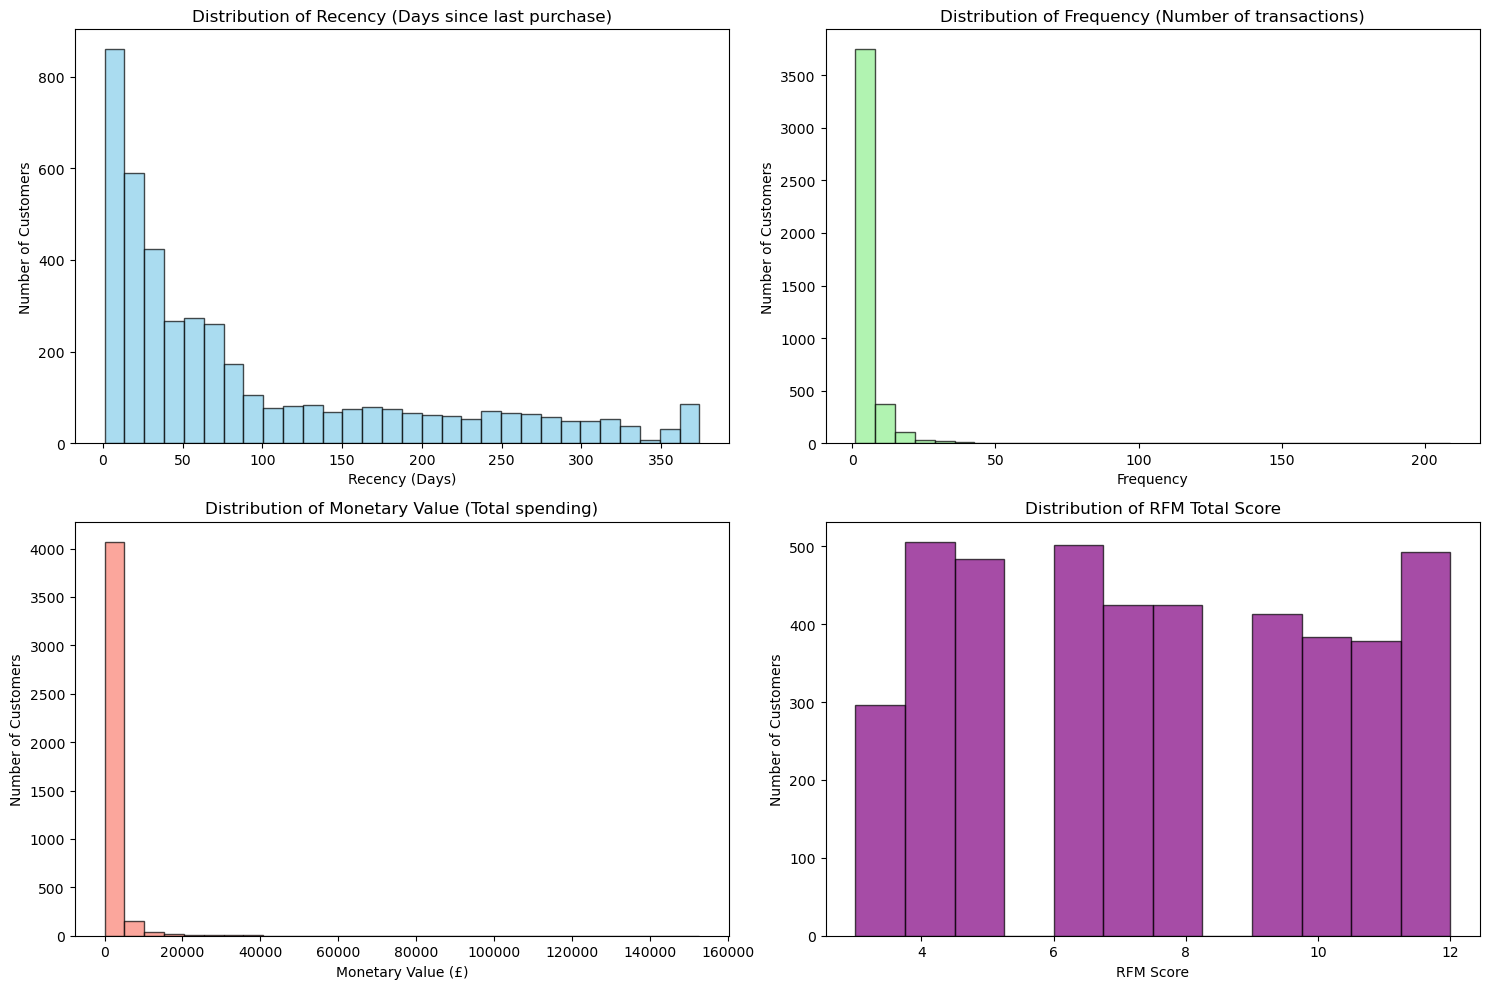

=== RFM METRICS SUMMARY ===
Recency - Average: 92.7 days, Median: 51.0 days
Frequency - Average: 4.2, Median: 2.0
Monetary - Average: £1,649.91, Median: £646.83
RFM Score - Average: 7.5, Median: 7.0


In [5]:
# Visualize the distribution of RFM metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Recency distribution
axes[0, 0].hist(rfm['Recency'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_title('Distribution of Recency (Days since last purchase)')
axes[0, 0].set_xlabel('Recency (Days)')
axes[0, 0].set_ylabel('Number of Customers')

# Frequency distribution
axes[0, 1].hist(rfm['Frequency'], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Distribution of Frequency (Number of transactions)')
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_ylabel('Number of Customers')

# Monetary distribution
axes[1, 0].hist(rfm['Monetary'], bins=30, edgecolor='black', alpha=0.7, color='salmon')
axes[1, 0].set_title('Distribution of Monetary Value (Total spending)')
axes[1, 0].set_xlabel('Monetary Value (£)')
axes[1, 0].set_ylabel('Number of Customers')

# RFM Score distribution
axes[1, 1].hist(rfm['RFM_Score'], bins=12, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_title('Distribution of RFM Total Score')
axes[1, 1].set_xlabel('RFM Score')
axes[1, 1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== RFM METRICS SUMMARY ===")
print(f"Recency - Average: {rfm['Recency'].mean():.1f} days, Median: {rfm['Recency'].median():.1f} days")
print(f"Frequency - Average: {rfm['Frequency'].mean():.1f}, Median: {rfm['Frequency'].median():.1f}")
print(f"Monetary - Average: £{rfm['Monetary'].mean():,.2f}, Median: £{rfm['Monetary'].median():,.2f}")
print(f"RFM Score - Average: {rfm['RFM_Score'].mean():.1f}, Median: {rfm['RFM_Score'].median():.1f}")

### Save the RFM Data

In [6]:
# Save the RFM data for clustering analysis
rfm.to_csv('../data/processed/rfm_data.csv', index=False)

print("RFM data saved to '../data/processed/rfm_data.csv'")
print(f"Final RFM dataset shape: {rfm.shape}")
print("\nData ready for customer segmentation modeling!")

RFM data saved to '../data/processed/rfm_data.csv'
Final RFM dataset shape: (4303, 9)

Data ready for customer segmentation modeling!
